In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Данные доступны по следующей ссылке:
- https://drive.google.com/drive/folders/1iyXY9mUOZXAKd722-lGeiJKmJflG4_az?usp=sharing

In [ ]:
!pip install transformers
!pip install annoy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, re, random
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import BertModel, BertTokenizer
from annoy import AnnoyIndex

In [ ]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    image = image.unsqueeze(0)
    return image

In [ ]:
def get_image_embedding(filename, image_path):
    image_embeddings = {}
    image_tensor = load_image(image_path)
    with torch.no_grad():
        image_embedding = model(image_tensor)
    image_embeddings[filename] = image_embedding
    return image_embeddings

In [ ]:
def get_text_embedding(text):
    text = text.lower()
    splits = text.split('| |')
    tokenized_text = [tokenizer.tokenize(split) for split in splits]
    tokenized_text = [' '.join(tokens) for tokens in tokenized_text]
    tokens = tokenizer.encode(tokenized_text, add_special_tokens=True)
    tokens_tensor = torch.tensor(tokens).unsqueeze(0)
    with torch.no_grad():
        last_hidden_states = bert_model(tokens_tensor)[0]
        text_embedding = torch.mean(last_hidden_states, dim=1).squeeze(0)
    return text_embedding

In [ ]:
def perform_search(image_folder, metadata, data, numNeighbors):
    similar_images = {}
    embeddings = data['combined_embedding'].values
    embedding_size = len(embeddings[0])
    annoy_index = AnnoyIndex(embedding_size, 'angular')
    for i, embedding in enumerate(embeddings):
        annoy_index.add_item(i, embedding)
    annoy_index.build(10)
    for filename in os.listdir(image_folder):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            image_path = os.path.join(image_folder, filename)
            query_image_embedding = get_image_embedding(filename, image_path)
            query_embedding = torch.cat((query_image_embedding[filename].reshape(1, -1), (metadata[filename].reshape(1, -1))), dim=1)
            num_neighbors = len(((numNeighbors.loc[numNeighbors['filename'] == filename, 'similar_images']).tolist())[0])
            nearest_neighbors = annoy_index.get_nns_by_vector(np.ravel(query_embedding), num_neighbors)
            file_names = []
            for index in nearest_neighbors:
                file_name = data['filename'][index]
                file_names.append(file_name)
            similar_images[filename] = file_names
    return similar_images

In [ ]:
def compute_average_precision(actual, predicted):
    if len(actual) == 0:
        return 0
    else:
        num_hits = 0
        precision_sum = 0
        for i, p in enumerate(predicted):
            if p in actual and p not in predicted[:i]:
                num_hits += 1
                precision = num_hits / (i + 1)
                precision_sum += precision
        average_precision = precision_sum / len(actual)
        return average_precision

def mean_average_precision(target_images, found_images):
    average_precisions = []
    for key, value in found_images.items():
        actual = ((target_images.loc[target_images['filename'] == key, 'similar_images']).tolist())[0]
        predicted = value
        average_precision = compute_average_precision(actual, predicted)
        average_precisions.append(average_precision)
    mean_average_precision = np.mean(average_precisions)
    return mean_average_precision

In [ ]:
def plot_images(image_folder_path, query_image_path, key, similar_df):
    plt.figure(figsize=(30, 20))
    #columns = 2
    key_name = key.split('.')[0]
    for i, image in enumerate(similar_df):
        image_name = image.split('.')[0]
        ax = plt.subplot(len(similar_df) // len(similar_df) + 1, len(similar_df), i + 1)
        if i == 0:
            _ = Image.open(query_image_path + "/" + key, 'r')
            ax.set_title("Query Image\n" + key_name)
        else:
            _ = Image.open(image_folder_path + "/" + image, 'r')
            ax.set_title("Similar Image\n" + image_name)
        plt.imshow(_)

In [ ]:
model = models.vgg16(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])
model.eval()

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model.eval()

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Practice:IR/metadata.csv')

train_df['Type'] = train_df['Type'].str.replace(r'[,.][^,.]*$', '', regex=True)
train_df["Type"] = train_df["Type"].str.replace(r'\d+\s*x\s*\d+\s*(mm|cm|KB)?', '', regex=True)
train_df['Type'] = train_df['Type'].str.replace(r',(\s*)?(\d+)?', '', regex=True)
train_df.loc[~train_df['Type'].str.contains('paper|oil|canvas|watercolor|gouache|chalk|pencil|panel'), 'Type'] = ' '
train_df.replace(np.NaN, " ", inplace = True)

for column in train_df.columns:
    train_df[column] = train_df[column].str.strip()

train_df.drop_duplicates(subset='Title', keep='last', inplace=True, ignore_index = True)
train_df['Title'] = train_df['Title'].str.replace(':', '_')
train_df['Title'] = train_df['Title'].str.replace('"', '_')
train_df['Title'] += ".jpg"

train_df['text'] = train_df.apply(lambda x: '| |'.join([str(x['Artist']), str(x['Year']), str(x['Type'])]), axis=1)
train_df

Title       Year  \
0               Allegory of Peace, Art and Abundance.jpg       1602   
1                         Jupiter, Antiope and Cupid.jpg    1595-98   
2                      Pallas Athena, Venus and Juno.jpg       1593   
3                           Bacchus, Ceres and Cupid.jpg  1595-1605   
4                           Bacchus, Venus and Cupid.jpg  1595-1600   
...                                                  ...        ...   
15307  Arrangement in Grey and Black Number 2_  Portr...    1872-73   
15308  Nocturne in Black and Gold_  The Falling Rocke...       1875   
15309  Arrangement in Brown and Black_  Miss Rosa Cor...    1876-78   
15310  Arrangement in Black_  The Lady in the Yellow ...    1882-84   
15311            Annabel Lee (Also known as _Niobe_).jpg       1890   

                        Type            Artist  \
0              Oil on canvas  AACHEN, Hans von   
1                             AACHEN, Hans von   
2              Oil on canvas  AACHEN, Hans von   
3              Oil on canvas  AACHEN, Hans von   
4              Oil on canvas  AACHEN, Hans von   
...                      ...               ...   
15307                                 Whistler   
15308                                 Whistler   
15309                                 Whistler   
15310                                 Whistler   
15311  pastel on brown paper          Whistler   

                                               text  
0           AACHEN, Hans von| |1602| |Oil on canvas  
1                     AACHEN, Hans von| |1595-98| |  
2           AACHEN, Hans von| |1593| |Oil on canvas  
3      AACHEN, Hans von| |1595-1605| |Oil on canvas  
4      AACHEN, Hans von| |1595-1600| |Oil on canvas  
...                                             ...  
15307                         Whistler| |1872-73| |  
15308                            Whistler| |1875| |  
15309                         Whistler| |1876-78| |  
15310                         Whistler| |1882-84| |  
15311       Whistler| |1890| |pastel on brown paper  

[15312 rows x 5 columns]

In [ ]:
train_df.loc[train_df['Title'] == 'Madonna & Child (The Small Cowper Madonna).jpg']

Title  Year Type   Artist  \
15040  Madonna & Child (The Small Cowper Madonna).jpg  1505       Raphael   

                    text  
15040  Raphael| |1505| |

In [ ]:
rows_to_split = [1063, 8230, 14801, 15040]
test_df = train_df.iloc[rows_to_split].reset_index(drop=True)
train_df = train_df.drop(rows_to_split).reset_index(drop=True)

test_df

Title  Year           Type  \
0                    The Four Elements_ Water.jpg  1569  Oil on canvas   
1                     Beach at Sainte-Adresse.jpg  1867  Oil on canvas   
2         Landscape with the Finding of Moses.jpg  1638                  
3  Madonna & Child (The Small Cowper Madonna).jpg  1505                  

                 Artist                                         text  
0   BEUCKELAER, Joachim   BEUCKELAER, Joachim| |1569| |Oil on canvas  
1  Paintings until 1867  Paintings until 1867| |1867| |Oil on canvas  
2               Lorrain                            Lorrain| |1638| |  
3               Raphael                            Raphael| |1505| |

In [ ]:
image_folder_path = '/content/drive/MyDrive/Practice:IR/train'
data = pd.DataFrame(columns=['filename', 'image_embedding', 'text', 'text_embedding', 'combined_embedding'])

i = 0
for filename in os.listdir(image_folder_path):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        text = train_df.loc[train_df['Title'] == filename]
        if text.empty:
            continue
        else:
            image_path = os.path.join(image_folder_path, filename)
            image_embedding = get_image_embedding(filename, image_path)
            index = text.index[0]
            df = pd.DataFrame(columns=data.columns)
            df['filename'] = image_embedding.keys()
            df['image_embedding'] = image_embedding.values()
            df['text'] = train_df['text'].iloc[index]
            data = pd.concat([data, df], ignore_index=True)
            i += 1
            print(i, filename)

for i in range(len(data)):
    data['text_embedding'].iloc[i] = get_text_embedding(data['text'].iloc[i])


batch_size = 20
for i in range(0, len(data), batch_size):
    batch = data.iloc[i:i + batch_size].copy()
    batch['combined_embedding'] = batch.apply(lambda x: torch.cat((x['image_embedding'].reshape(1, -1), x['text_embedding'].reshape(1, -1)), dim=1), axis=1)
    data.update(batch['combined_embedding'])

D1_arrays = []
for tensor in data['combined_embedding']:
    D1_array = np.ravel(tensor)
    D1_arrays.append(D1_array)
data['combined_embedding'] = D1_arrays

query_image_path = '/content/drive/MyDrive/Practice:IR/test'  # путь к входному изображению
query_metadata = {}
for i in range(len(test_df)):
    query_metadata[test_df['Title'].iloc[i]] = get_text_embedding(test_df['text'].iloc[i])

Выходные данные были обрезаны до нескольких последних строк (5000).
9608 Gutenberg.jpg
9609 Guardroom Interior.jpg
9610 Gypsy Girl (Zingarella).jpg
9611 Guardroom Scene.jpg
9612 Gypsy Fortune Teller.jpg
9613 Haarlem_ View of the Town Hall.jpg
9614 Group of Figures Holding Book.jpg
9615 Group of Eleven Figures (Allegory of Autumn).jpg
9616 Gypsy Wedding Banquet.jpg
9617 Grove.jpg
9618 Hacienda.jpg
9619 Hagar and Ismail in the Desert.jpg
9620 Guizot or the Bore.jpg
9621 Guerrilla Warfare (Picket Duty in Virginia).jpg
9622 Guardroom.jpg
9623 Group of Children.jpg
9624 Guessing Game.jpg
9625 Gypsies in the Market.jpg
9626 Hair comb.jpg
9627 Hall of the Sacrifices (detail).jpg
9628 Harbour of Honfleur.jpg
9629 Hamlet.jpg
9630 Hairy Harry, Mad Peter and Tiny Amon.jpg
9631 Hairy Harry, Mad Peter and Tiny Amon (detail).jpg
9632 Hall in the Appartamento Estivo.jpg
9633 Hall of the Triumphs (detail).jpg
9634 Hand with Reflecting Globe.jpg
9635 Harbour Scene with Grieving Heliades.jpg
9636 Hare.j

Mean Average Precision: 0.7997222222222222


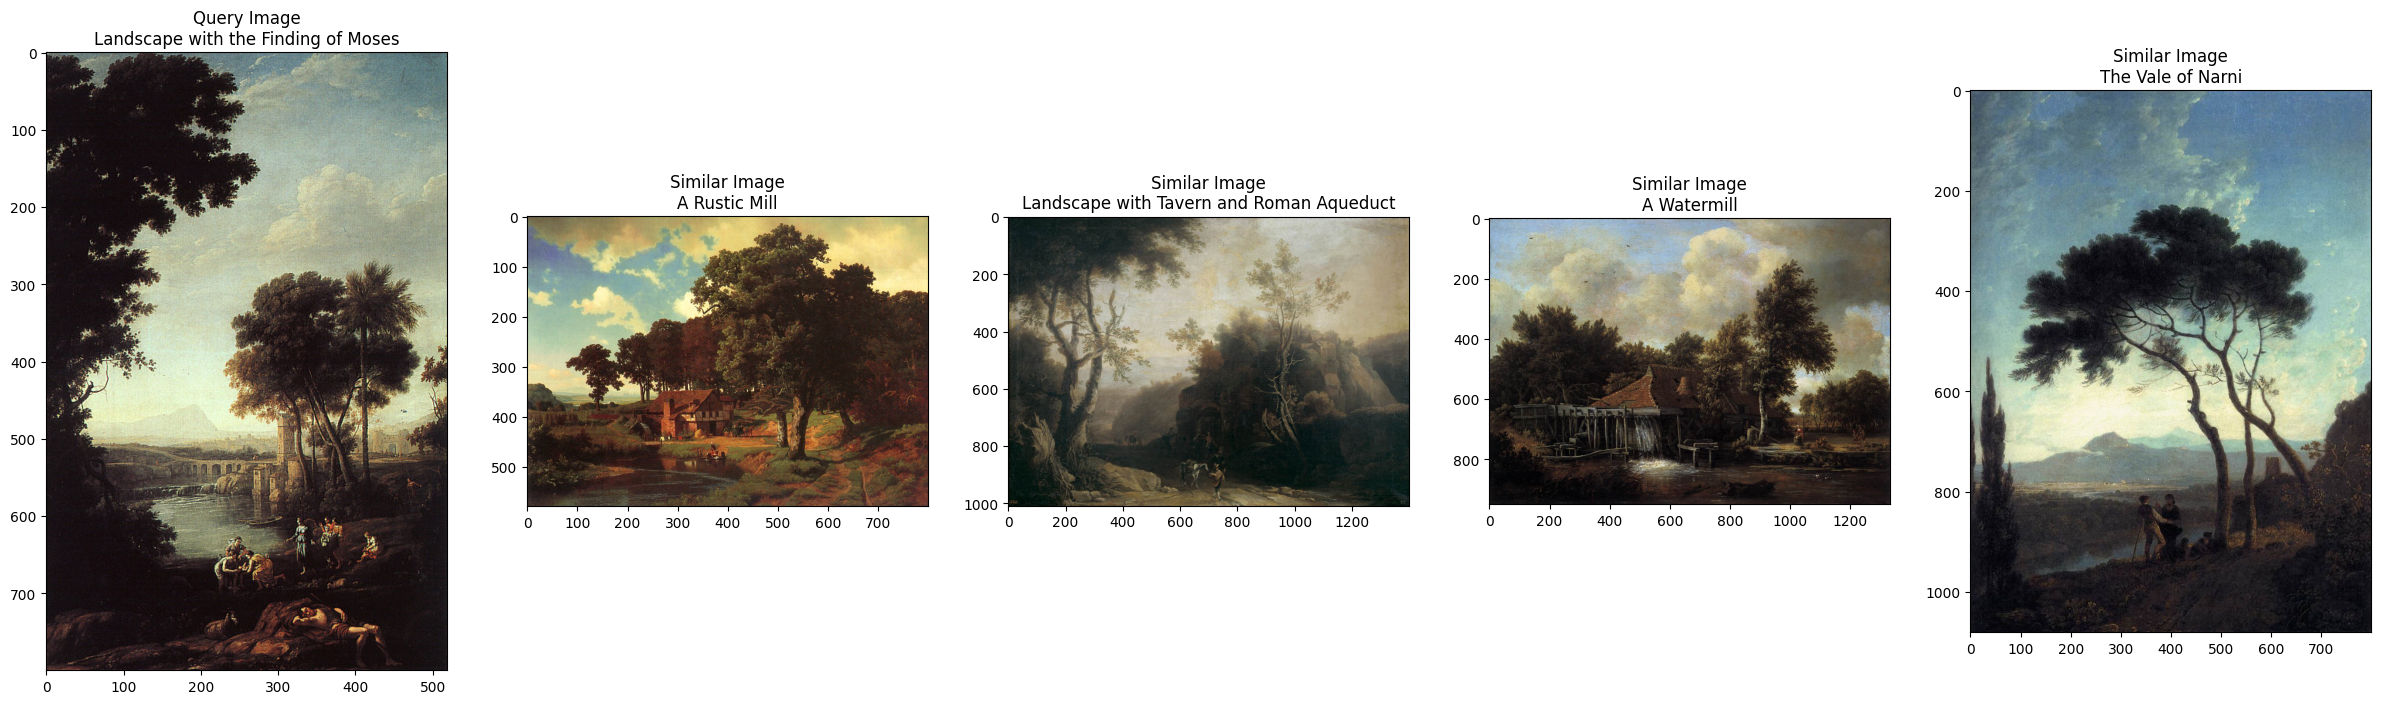

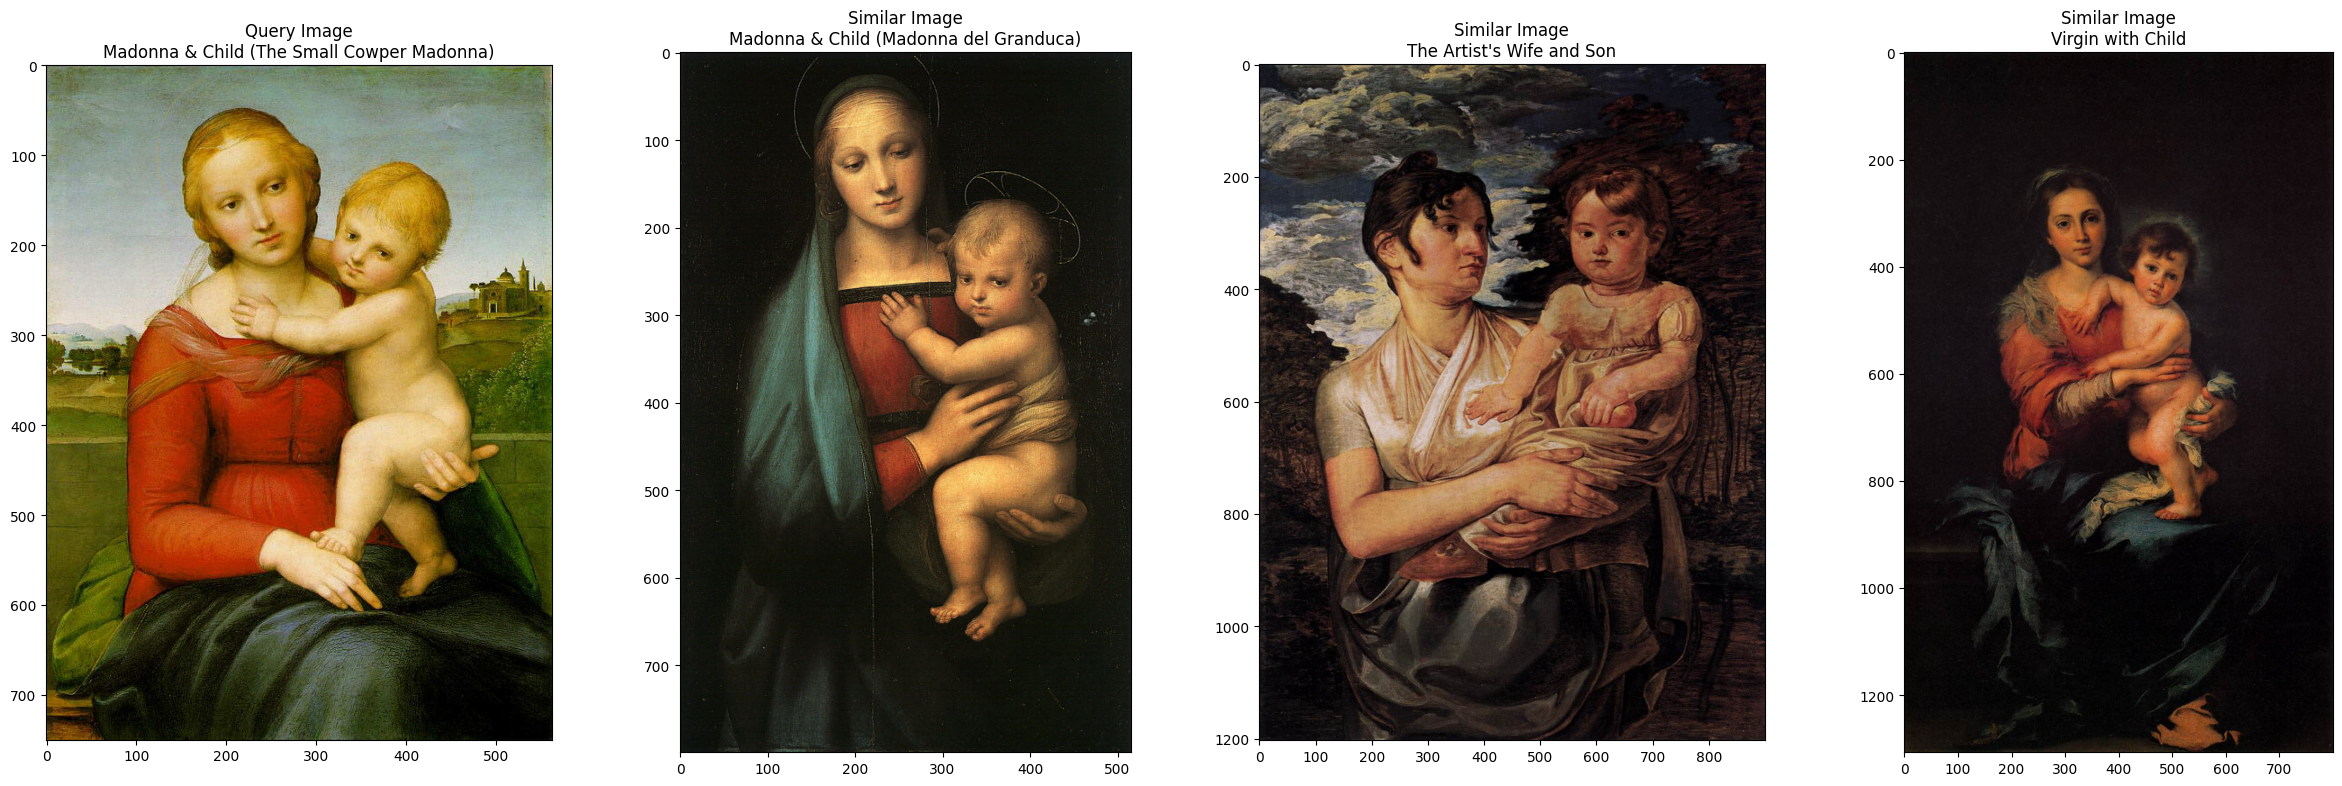

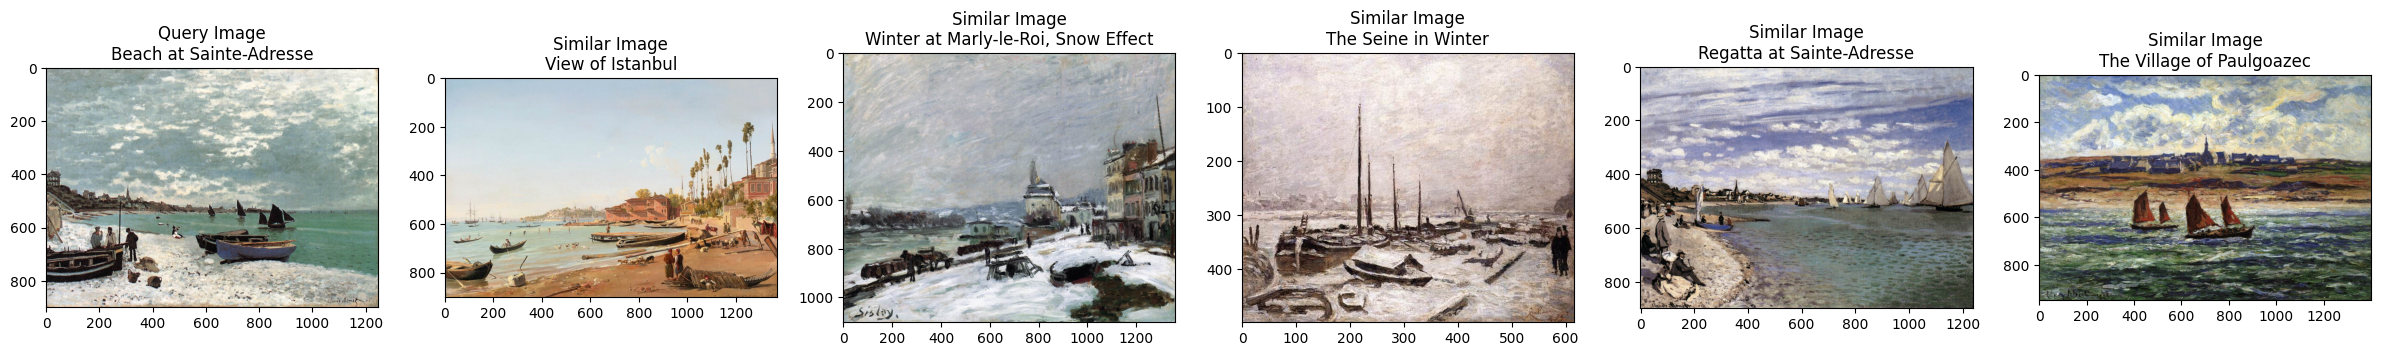

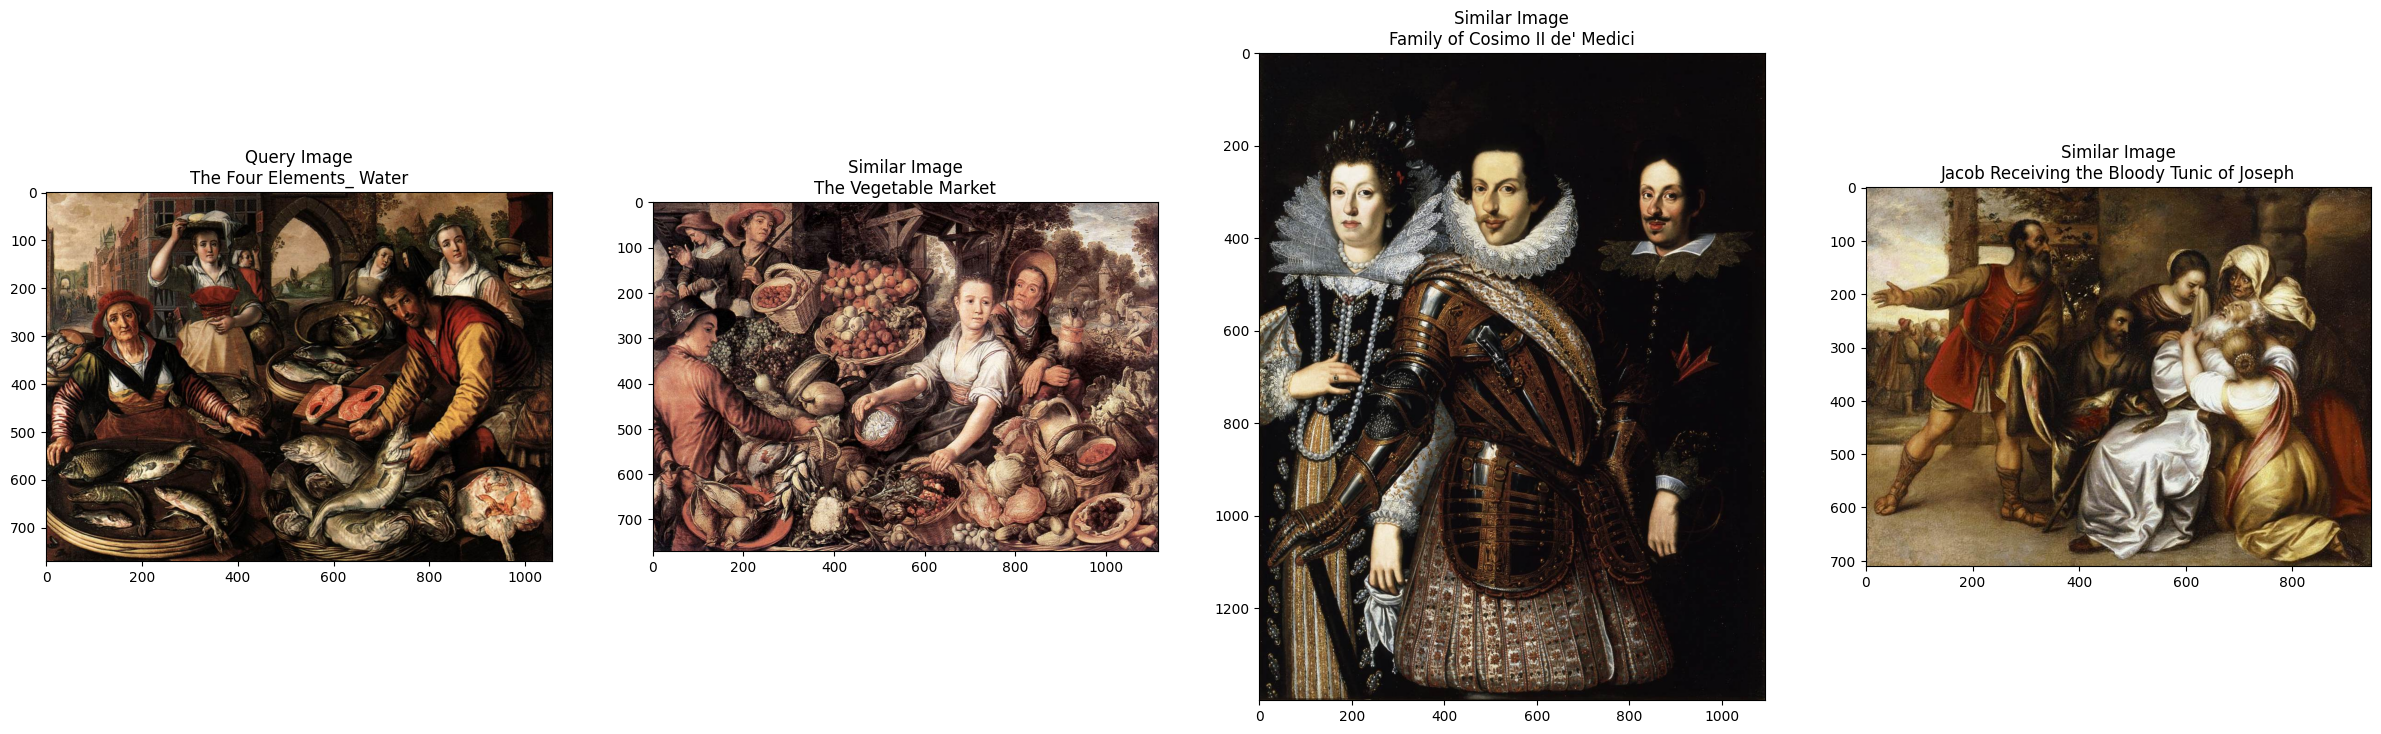

In [ ]:
actual = {'filename': ['Landscape with the Finding of Moses.jpg', 'Madonna & Child (The Small Cowper Madonna).jpg',
                       'The Four Elements_ Water.jpg', 'Beach at Sainte-Adresse.jpg'],
          'similar_images': [['A Rustic Mill.jpg', 'Landscape with Tavern and Roman Aqueduct.jpg', 'The Vale of Narni.jpg', 'A Watermill.jpg'],
                             ['Madonna & Child (Madonna del Granduca).jpg', 'Virgin with Child.jpg', "The Artist's Wife and Son.jpg"],
                             ['The Vegetable Market.jpg', 'The Four Elements_ Fire.jpg', 'Jacob Receiving the Bloody Tunic of Joseph.jpg'],
                             ['View of Istanbul.jpg', 'Beach at Heist.jpg', 'The Seine in Winter.jpg', 'Regatta at Sainte-Adresse.jpg', 'The Village of Paulgoazec.jpg']]}

target_images = pd.DataFrame(actual)

found_images = perform_search(query_image_path, query_metadata, data, target_images)
MAP_value = mean_average_precision(target_images, found_images)

for key, value in found_images.items():
    merged_list = [key] + value
    df = pd.DataFrame()
    df['Images'] = merged_list
    plot_images(image_folder_path, query_image_path, key, df['Images'])

print("Mean Average Precision:", MAP_value)

In [ ]:
found_images

{'Landscape with the Finding of Moses.jpg': ['A Rustic Mill.jpg',
  'Landscape with Tavern and Roman Aqueduct.jpg',
  'A Watermill.jpg',
  'The Vale of Narni.jpg'],
 'Madonna & Child (The Small Cowper Madonna).jpg': ['Madonna & Child (Madonna del Granduca).jpg',
  "The Artist's Wife and Son.jpg",
  'Virgin with Child.jpg'],
 'Beach at Sainte-Adresse.jpg': ['View of Istanbul.jpg',
  'Winter at Marly-le-Roi, Snow Effect.jpg',
  'The Seine in Winter.jpg',
  'Regatta at Sainte-Adresse.jpg',
  'The Village of Paulgoazec.jpg'],
 'The Four Elements_ Water.jpg': ['The Vegetable Market.jpg',
  "Family of Cosimo II de' Medici.jpg",
  'Jacob Receiving the Bloody Tunic of Joseph.jpg']}

In [ ]:
data

filename  \
0                                 View of Amersfoort.jpg   
1                        View of a Villa with a Pool.jpg   
2                             View of Gamborg on Fyn.jpg   
3                       View of Dresden at Full Moon.jpg   
4                        View of El Arenal in Bilbao.jpg   
...                                                  ...   
14602                  A Scene in the Roman Campagna.jpg   
14603                A Scene from the Beggar's Opera.jpg   
14604                                    A Sea-Spell.jpg   
14605  A Scene in the Grounds of the Villa Farnese, R...   
14606               A Section of the Via Sacra, Rome.jpg   

                                         image_embedding  \
0      [[[tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0...   
1      [[[tensor([0., 0., 0., 0., 0., 0., 0.]), tenso...   
2      [[[tensor([1.4380, 1.0588, 0.0000, 0.0000, 0.0...   
3      [[[tensor([0.6511, 0.0000, 0.0000, 0.5834, 0.7...   
4      [[[tensor([0., 0., 0., 0., 0., 0., 0.]), tenso...   
...                                                  ...   
14602  [[[tensor([0., 0., 0., 0., 0., 0., 0.]), tenso...   
14603  [[[tensor([0.4988, 0.0000, 0.0000, 0.0000, 3.9...   
14604  [[[tensor([0., 0., 0., 0., 0., 0., 0.]), tenso...   
14605  [[[tensor([0.6833, 0.0000, 0.0000, 0.5389, 2.4...   
14606  [[[tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0...   

                                                    text  \
0            WITHOOS, Matthias| |c. 1671| |Oil on canvas   
1                            URBANI, Andrea| |1764-68| |   
2               JUEL, Jens Jørgensen| |-| |Oil on canvas   
3      DAHL, Johan Christian Clausen| |1839| |Oil on ...   
4        PARET Y ALCAZÁR, Luis| |1783-84| |Oil on canvas   
...                                                  ...   
14602   BLOEMEN, Jan Frans van| |c. 1736| |Oil on canvas   
14603         HOGARTH, William| |1728-29| |Oil on canvas   
14604  ROSSETTI, Dante Gabriel| |1875-77| |Oil on canvas   
14605  Paintings of Italian subjects| |c. 1765| |Oil ...   
14606  ECKERSBERG, Christoffer Wilhelm| |1814-15| |Oi...   

                                          text_embedding  \
0      [tensor(-0.2922), tensor(0.3292), tensor(-0.29...   
1      [tensor(-0.2922), tensor(0.3292), tensor(-0.29...   
2      [tensor(-0.4964), tensor(-0.0052), tensor(-0.2...   
3      [tensor(-0.4359), tensor(0.1355), tensor(-0.08...   
4      [tensor(-0.2922), tensor(0.3292), tensor(-0.29...   
...                                                  ...   
14602  [tensor(-0.2922), tensor(0.3292), tensor(-0.29...   
14603  [tensor(-0.2922), tensor(0.3292), tensor(-0.29...   
14604  [tensor(-0.2922), tensor(0.3292), tensor(-0.29...   
14605  [tensor(-0.2922), tensor(0.3292), tensor(-0.29...   
14606  [tensor(-0.2922), tensor(0.3292), tensor(-0.29...   

                                      combined_embedding  
0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.06997304, 0.009329...  
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.462...  
2      [1.4379609, 1.0588273, 0.0, 0.0, 0.0, 0.0, 0.2...  
3      [0.65110236, 0.0, 0.0, 0.5834204, 0.71741897, ...  
4      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5714403,...  
...                                                  ...  
14602  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.394...  
14603  [0.49875286, 0.0, 0.0, 0.0, 3.9202564, 3.73724...  
14604  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
14605  [0.68333906, 0.0, 0.0, 0.53892505, 2.409322, 0...  
14606  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3113349, 2.11...  

[14607 rows x 5 columns]